In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid
from time import time
import tensorflow as tf


# Crop yield dataset

In [3]:
df = pd.read_csv("C:/Users/laura/OneDrive/Documents/GitHub/AISE_Group9/crop_yield_dataset.csv")
df = df.set_index('Date')
df.drop("Crop_Type",axis=1,inplace=True)
wheat = df.iloc[::10].copy()
corn = df.iloc[1::10].copy()
df = corn[["Crop_Yield","Temperature","Humidity"]]

In [4]:
df.shape

(3652, 3)

In [38]:
test_split=round(len(df)*0.20)
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(2922, 3)
(730, 3)


In [39]:
scaler = MinMaxScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
#df_for_training_scaled

In [7]:
def createXY(dataset,time_step):
    dataX = []
    dataY = []
    for i in range(len(dataset)-time_step):
            dataX.append(dataset[i:i + time_step])
            dataY.append(dataset[i + time_step])
    return np.array(dataX),np.array(dataY)


In [17]:
X_train, y_train=createXY(df_for_training_scaled,10)
X_test,y_test=createXY(df_for_testing_scaled,10)

In [18]:
print("trainX Shape-- ",X_train.shape)
print("trainY Shape-- ",y_train.shape)

trainX Shape--  (2912, 10, 3)
trainY Shape--  (2912, 3)


In [12]:
# hyperparameter tuning for number of layers and batch size
param_grid = {
    'layers': [2,3], #LSTM layers
    'units1': [150,100],
    'units2': [100,50] #number of LSTM units
}

In [22]:
def evaluate_model(layers,units1,units2):
    model = Sequential()
    n_samples, n_timesteps, n_features = X_train.shape[0],X_train.shape[1],X_train.shape[2]
    for i in range(layers-1): #add one layer per number inputted
        model.add(LSTM(units2,activation='relu',input_shape=(n_timesteps, n_features),return_sequences=True))
    model.add(LSTM(units1,activation='relu',return_sequences=False))
    model.add(Dense(3)) #3 outputs
    model.compile(optimizer='adam',loss='mae')

    epochs = 50
    validation_split = 0.2
    batch_size = 64
    model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=validation_split,verbose=1,shuffle=True)
    y_pred = model.predict(X_test, verbose=0)

    mae = np.sqrt(mean_absolute_error(y_test,y_pred))

    return mae


In [23]:
best_mae = 1
best_params = None
for params in ParameterGrid(param_grid):
    print(f"Testing with parameters: {params}")
    mae = evaluate_model(params['layers'], params['units1'],params['units2'])
    print(f"MAE: {mae:.4f}")

    if mae < best_mae:
        best_mae = mae
        best_params = params

print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae:.4f}")

Testing with parameters: {'layers': 2, 'units1': 150, 'units2': 100}
Epoch 1/50
37/37 [==============================] - 11s 199ms/step - loss: 0.2215 - val_loss: 0.1251
Epoch 2/50
37/37 [==============================] - 8s 205ms/step - loss: 0.1112 - val_loss: 0.1164
Epoch 3/50
37/37 [==============================] - 7s 183ms/step - loss: 0.1089 - val_loss: 0.1115
Epoch 4/50
37/37 [==============================] - 5s 126ms/step - loss: 0.1083 - val_loss: 0.1133
Epoch 5/50
37/37 [==============================] - 7s 188ms/step - loss: 0.1086 - val_loss: 0.1094
Epoch 6/50
37/37 [==============================] - 7s 193ms/step - loss: 0.1061 - val_loss: 0.1098
Epoch 7/50
37/37 [==============================] - 7s 179ms/step - loss: 0.1070 - val_loss: 0.1100
Epoch 8/50
37/37 [==============================] - 8s 231ms/step - loss: 0.1062 - val_loss: 0.1103
Epoch 9/50
37/37 [==============================] - 7s 178ms/step - loss: 0.1051 - val_loss: 0.1135
Epoch 10/50
37/37 [===========

KeyboardInterrupt: 

In [58]:
print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_mae:.4f}")

Best Parameters: {'layers': 3, 'units1': 100, 'units2': 50}
Best RMSE: 0.1460


In [111]:
# train model with best params
n_samples, n_timesteps, n_features = X_train.shape[0],X_train.shape[1],X_train.shape[2]
model_LSTM = Sequential()
model_LSTM.add(LSTM(100, activation='relu', input_shape=(n_timesteps, n_features),return_sequences=True)) #return_sequences is necessary for stacked LSTM so that output includes timestamps (3D)
model_LSTM.add(LSTM(50, activation='relu', return_sequences=True))
model_LSTM.add(LSTM(50, activation='relu'))
model_LSTM.add(Dense(3)) #3 output variables (yield, temperature, humidity)
model_LSTM.compile(optimizer='adam', loss='mae')

In [112]:
epochs = 100
validation_split = 0.2
batch_size = 64

st = time()
model_LSTM_trained = model_LSTM.fit(X_train,y_train,epochs=epochs,validation_split=validation_split,verbose=1,shuffle=True)
et = time()
train_t_LSTM = et-st

Epoch 1/100
73/73 [==============================] - 9s 56ms/step - loss: 0.2443 - val_loss: 0.1364
Epoch 2/100
73/73 [==============================] - 5s 63ms/step - loss: 0.1250 - val_loss: 0.1131
Epoch 3/100
73/73 [==============================] - 7s 93ms/step - loss: 0.1202 - val_loss: 0.1156
Epoch 4/100
73/73 [==============================] - 3s 45ms/step - loss: 0.1196 - val_loss: 0.1146
Epoch 5/100
73/73 [==============================] - 5s 64ms/step - loss: 0.1190 - val_loss: 0.1146
Epoch 6/100
73/73 [==============================] - 4s 50ms/step - loss: 0.1213 - val_loss: 0.1117
Epoch 7/100
73/73 [==============================] - 3s 44ms/step - loss: 0.1185 - val_loss: 0.1172
Epoch 8/100
73/73 [==============================] - 4s 49ms/step - loss: 0.1180 - val_loss: 0.1115
Epoch 9/100
73/73 [==============================] - 19s 262ms/step - loss: 0.1187 - val_loss: 0.1115
Epoch 10/100
73/73 [==============================] - 8s 103ms/step - loss: 0.1170 - val_loss: 0.1

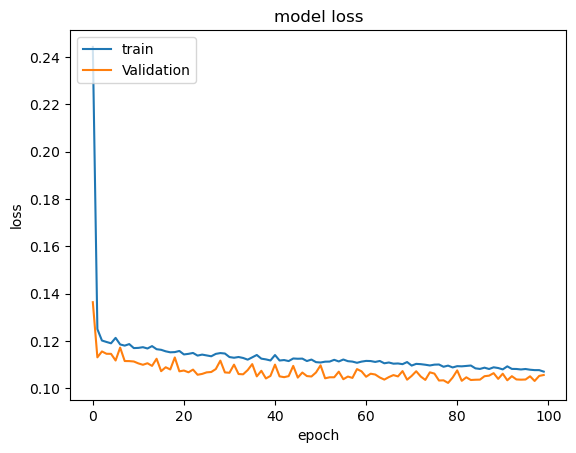

In [113]:
plt.plot(model_LSTM_trained.history['loss'])
plt.plot(model_LSTM_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [114]:
# Evaluate LSTM
loss_lstm = model_LSTM.evaluate(X_test, y_test, verbose=0)
y_pred_lstm = model_LSTM.predict(X_test, verbose=0)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = root_mean_squared_error(y_test,y_pred_lstm)

print(f"LSTM Loss (MAE): {loss_lstm}")
print(f"LSTM RMSE: {rmse_lstm}")
print(f"LSTM Time: {train_t_LSTM}")

LSTM Loss (MAE): 0.11010819673538208
LSTM RMSE: 0.15024705149443965
LSTM Time: 316.1465895175934


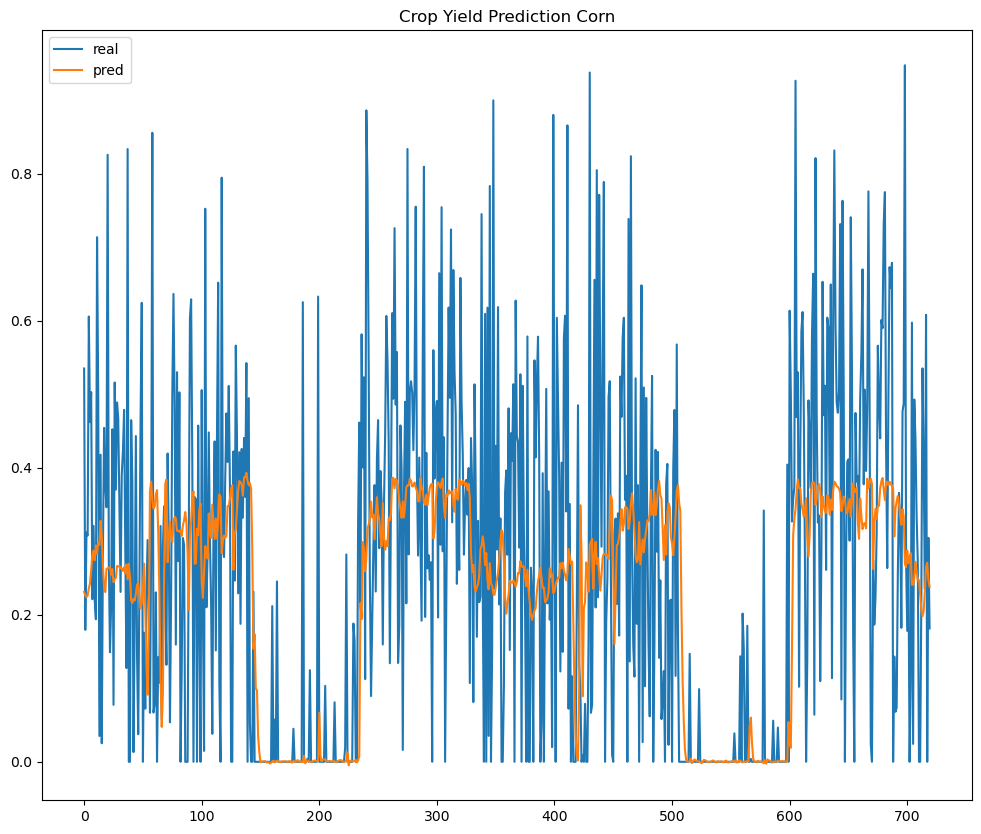

In [115]:
plt.figure(figsize=(12,10))
plt.plot(y_test[:,0],label="real")
plt.plot(y_pred_lstm[:,0],label="pred")
plt.title('Crop Yield Prediction Corn')
plt.legend()

In [ ]:
# this forecasting stuff definitely isn't right but idk how to fix it :/
starting = X_test[-1].reshape(1, 10, 3)  # get the last 10 days of data, now with 3 features per day
days = 10  # predict for 100 days
forecast = np.zeros(shape=(days, 3))  # array to hold results, adjust size as needed (this is for 48 features, adjust accordingly)

for i in range(days):  # predict for 100 days
    nextPreds = model_LSTM.predict(starting, verbose=0)  # predict the next day
    forecast[i] = nextPreds.reshape(-1)  # save the prediction, reshaping the 3 values per day to fit the forecast array
    
    # Prepare for the next day
    roll = starting[0][1:]  # remove the oldest day of data (shift left)
    roll = np.append(roll, nextPreds, axis=0)  # add the new prediction (shape should match)
    starting = roll.reshape(1, 10, 3)

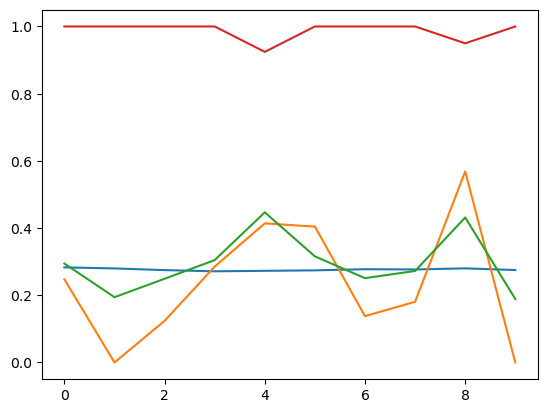

In [141]:
plt.plot(forecast[:,1])
plt.plot(X_test[:,0][0:10])

# City dataset

In [90]:
df1 = pd.read_csv("weather_data_kolkata_2015_2020.csv")
df1["time"]=pd.to_datetime(df1["DATETIME"]).dt.date
df1["Crop_Yield"]=0

In [91]:
df1.head()

,DATETIME,TEMPERATURE,HUMIDITY,time,Crop_Yield
0,2015-01-01 00:00:00,19.0,75.0,2015-01-01,0
1,2015-01-01 01:00:00,19.0,77.0,2015-01-01,0
2,2015-01-01 02:00:00,19.0,78.0,2015-01-01,0
3,2015-01-01 03:00:00,19.0,80.0,2015-01-01,0
4,2015-01-01 04:00:00,19.0,81.0,2015-01-01,0


In [92]:
df1 = df1[["time","Crop_Yield","TEMPERATURE","HUMIDITY"]]

In [93]:
df1.set_index("time",inplace=True)

In [94]:
df1.sort_index(inplace=True)

In [95]:
df1.isna().sum()

,0
Crop_Yield,0
TEMPERATURE,0
HUMIDITY,0


In [96]:
df1.head()

,Crop_Yield,TEMPERATURE,HUMIDITY
time,,,
2015-01-01,0,19.0,75.0
2015-01-01,0,19.0,77.0
2015-01-01,0,19.0,78.0
2015-01-01,0,19.0,80.0
2015-01-01,0,19.0,81.0


In [97]:
df1.shape

(52608, 3)

In [98]:
test_split=round(len(df1)*0.20)
df1_training=df1[:-test_split]
df1_testing=df1[-test_split:]
print(df1_training.shape)
print(df1_testing.shape)

(42086, 3)
(10522, 3)


In [99]:
scaler = MinMaxScaler()
df1_training_scaled = scaler.fit_transform(df_for_training)
df1_testing_scaled=scaler.transform(df_for_testing)

In [100]:
df_for_training_scaled[0:5]

array([[0.        , 0.23529412, 0.74444444],
       [0.        , 0.23529412, 0.76666667],
       [0.        , 0.23529412, 0.77777778],
       [0.        , 0.23529412, 0.8       ],
       [0.        , 0.23529412, 0.81111111]])

In [101]:
X_train, y_train=createXY(df1_training_scaled,30)
X_test,y_test=createXY(df1_testing_scaled,30)

In [106]:
# use LSTM to pred and forecast
n_samples, n_timesteps, n_features = X_train.shape[0],X_train.shape[1],X_train.shape[2]
model_weather = Sequential()
model_weather.add(LSTM(100, activation='relu', input_shape=(n_timesteps, n_features),return_sequences=True)) #return_sequences is necessary for stacked LSTM so that output includes timestamps (3D)
model_weather.add(LSTM(50, activation='relu'))
model_weather.add(Dense(3)) #3 output variables (crop yield (0), temperature, humidity)
model_weather.compile(optimizer='adam', loss='mae')

In [107]:
epochs = 10
validation_split = 0.2
batch_size = 128

st = time()
model_LSTM_trained = model_weather.fit(X_train,y_train,epochs=epochs,validation_split=validation_split,verbose=False,shuffle=True)
et = time()
train_t_LSTM = et-st

KeyboardInterrupt: 

In [ ]:
plt.plot(model_LSTM_trained.history['loss'])
plt.plot(model_LSTM_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [125]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate LSTM
loss_lstm = model_weather.evaluate(X_test, y_test, verbose=0)
y_pred_lstm = model_weather.predict(X_test, verbose=0)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)

print(f"LSTM Loss (MAE): {loss_lstm}")
print(f"LSTM MSE: {mse_lstm}")
print(f"LSTM RMSE: {rmse_lstm}")
print(f"LSTM Time: {train_t_LSTM}")

LSTM Loss (MAE): 0.015721092000603676
LSTM MSE: 0.000435296888529255
LSTM RMSE: 0.020863769758345568
LSTM Time: 395.76572608947754


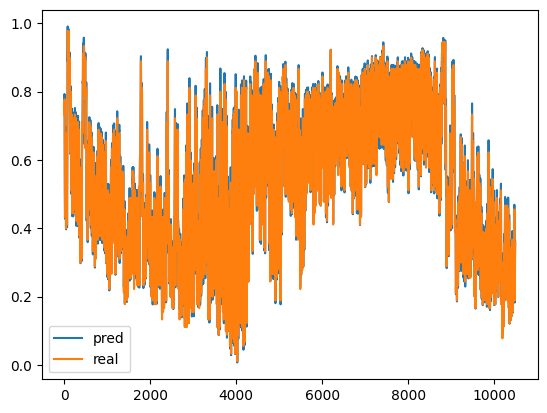

In [126]:
plt.plot(y_pred_lstm[:,1],label="pred")
plt.plot(y_test[:,1],label="real")
plt.legend()

In [128]:
# use GRU to pred and forecast
n_samples, n_timesteps, n_features = X_train.shape[0],X_train.shape[1],X_train.shape[2]
model_weather = Sequential()
model_weather.add(GRU(100, activation='relu', input_shape=(n_timesteps, n_features),return_sequences=True)) #return_sequences is necessary for stacked LSTM so that output includes timestamps (3D)
model_weather.add(GRU(50, activation='relu'))
model_weather.add(Dense(2)) #2 output variables ( temperature, humidity)
model_weather.compile(optimizer='adam', loss='mae')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [129]:
epochs = 10
validation_split = 0.2
batch_size = 128

st = time()
model_GRU_trained = model_weather.fit(X_train,y_train,epochs=epochs,validation_split=validation_split,verbose=False,shuffle=True)
et = time()
train_t_GRU = et-st

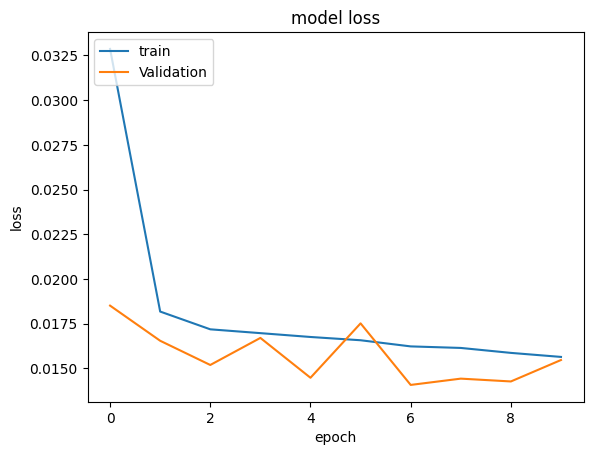

In [130]:
plt.plot(model_GRU_trained.history['loss'])
plt.plot(model_GRU_trained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [131]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate GRU
loss_gru = model_weather.evaluate(X_test, y_test, verbose=0)
y_pred_gru = model_weather.predict(X_test, verbose=0)
mse_gru = mean_squared_error(y_test, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)

print(f"GRU Loss (MAE): {loss_gru}")
print(f"GRU MSE: {mse_gru}")
print(f"GRU RMSE: {rmse_gru}")
print(f"GRU Time: {train_t_GRU}")

GRU Loss (MAE): 0.01530508790165186
GRU MSE: 0.0004066963661304661
GRU RMSE: 0.020166714311718358
GRU Time: 741.8742344379425


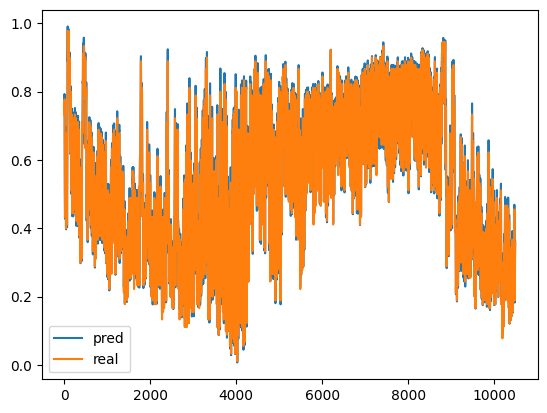

In [132]:
plt.plot(y_pred_lstm[:,1],label="pred")
plt.plot(y_test[:,1],label="real")
plt.legend()

In [ ]:
def create_dataset_with_sliding_window(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])  # Sequence of past n_steps timesteps
        y.append(data[i + n_steps])    # Target is the next timestep
    return np.array(X), np.array(y)

# Example: Creating the sliding window dataset
n_steps = 10  # Number of past timesteps the model will look at
data = np.random.rand(100, 3)  # 100 timesteps, 3 features (multivariate)
X, y = create_dataset_with_sliding_window(data, n_steps)

# End

In [148]:
X_forecast, y_forecast2=createXY(df_for_training_scaled,30)


In [149]:
X_forecast.shape

(42056, 30, 3)

In [133]:
y_forecast = model_LSTM.predict(X_forecast, verbose=0)


In [150]:
y_forecast1=model_LSTM.predict(X_forecast)

1315/1315 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step


In [151]:
y_forecast1[0:10]

array([[0.18177137, 0.48478004, 0.82132417],
       [0.1573968 , 0.5020019 , 0.7932784 ],
       [0.11497256, 0.53433007, 0.7433081 ],
       [0.07144393, 0.56919897, 0.6894446 ],
       [0.03398173, 0.59859324, 0.64266634],
       [0.01312238, 0.6169655 , 0.6111141 ],
       [0.00469964, 0.62626916, 0.59321296],
       [0.00273151, 0.6311885 , 0.5831718 ],
       [0.00374614, 0.6323811 , 0.5810343 ],
       [0.00468684, 0.6321603 , 0.583584  ]], dtype=float32)

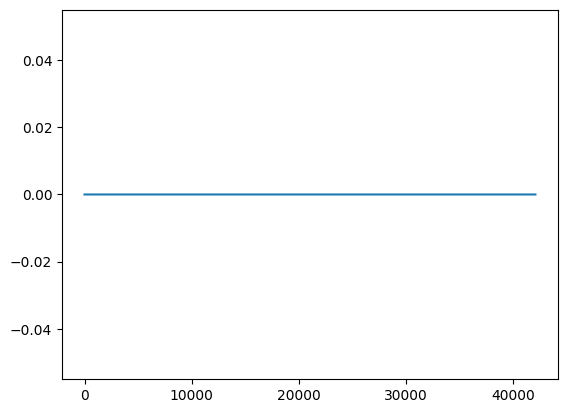

In [156]:
plt.plot(y_train[:,0])

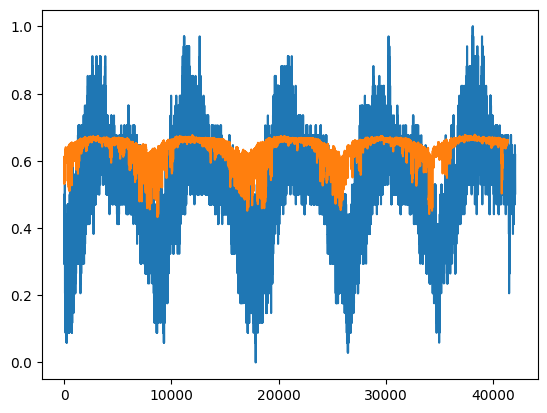

In [160]:
#plt.plot(y_forecast1[:,1])
plt.plot(y_train[:,1])
plt.plot(y_forecast[:,1])


In [161]:
df1.head()

,Crop_Yield,TEMPERATURE,HUMIDITY
time,,,
2015-01-01,0,19.0,75.0
2015-01-01,0,19.0,77.0
2015-01-01,0,19.0,78.0
2015-01-01,0,19.0,80.0
2015-01-01,0,19.0,81.0


In [167]:
df.sort_index(inplace=True)

In [168]:
df.head()

,Crop_Yield,Temperature,Humidity
Date,,,
2014-01-01,0.000000,9.440599,80.0
2014-01-02,28.723530,16.044318,80.0
2014-01-03,0.000000,1.901274,80.0
2014-01-04,50.066525,16.074694,80.0
2014-01-05,2.151818,10.402879,80.0


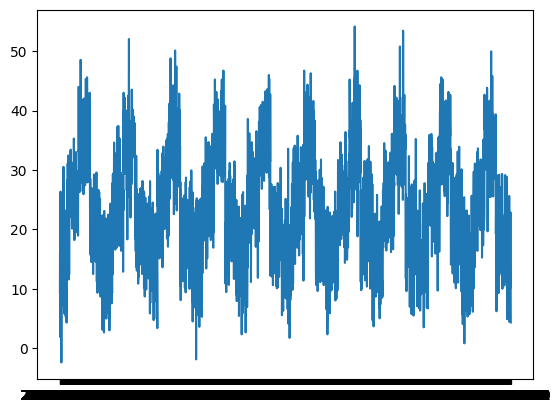

In [169]:
plt.plot(df.index,df['Temperature'])

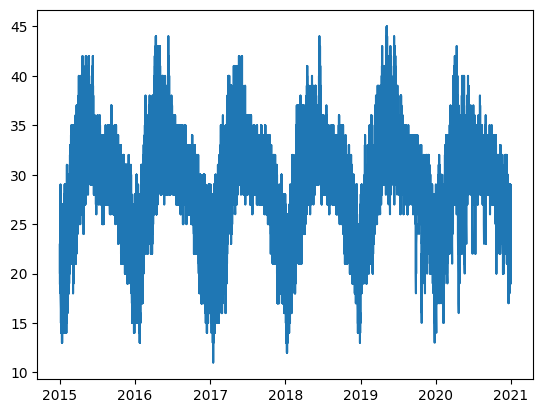

In [162]:
plt.plot(df1["TEMPERATURE"])